In [2]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
#import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime
from scipy.stats import ttest_ind

import seaborn as sns
sns.set_theme(style='white')
from tqdm import tqdm

from scipy.stats import spearmanr,kruskal,mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, get_treatment_info, load_from_pickle

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


region_colors_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(region_colors_dict.keys())
region_colors = list(region_colors_dict.values())

sample_class_dict = dict(zip(sample_id_masks.keys(),[s.split(' ')[0] for s in sample_id_masks.values()]))

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-k1nofxyn because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Data downloads

### Load and format score dataframe objects

In [6]:
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
#gene_set_df.columns = gene_set_df.columns + '_score'

scanpy_res = pd.concat(load_from_pickle('./data/spatial_scanpy_score_results.pkl'))
scanpy_res.index = scanpy_res.index.get_level_values(1)
#scanpy_res.columns = [c + '_score' for c in scanpy_res.columns]

# Extract the score names
gene_modules = gene_set_df.columns

all_obs = pd.read_csv('./data/pathology_filtered_obs_with_regions.csv',index_col=0)

if (scanpy_res.index == all_obs.index).all():
    all_obs = pd.concat([all_obs,scanpy_res],axis=1)

all_obs

,in_tissue,array_row,array_col,n_counts,size_factors,sample_id,sample_class,predicted_region,masked_id,CRPCsig51,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
BPH_651_AAACATTTCCCGGATT-1,1,61,97,4895.0,0.718688,BPH_651,BPH,Fibroblast,BPH 3,-0.088349,...,0.056750,0.247593,-0.073460,0.227149,0.099414,0.092692,0.074233,0.074233,-0.059659,0.088493
BPH_651_AAACCGGGTAGGTACC-1,1,42,28,4391.0,0.645273,BPH_651,BPH,Muscle,BPH 3,-0.017771,...,0.028903,0.228510,-0.050373,0.093866,0.052255,0.136955,0.047258,0.033789,0.080374,0.083837
BPH_651_AAACCGTTCGTCCAGG-1,1,52,42,8268.0,1.137046,BPH_651,BPH,Immune,BPH 3,0.054481,...,0.139896,0.230619,-0.045354,0.117626,0.088884,0.121908,0.117941,0.134488,0.097419,0.090068
BPH_651_AAACCTAAGCAGCCGG-1,1,65,83,9894.0,1.518961,BPH_651,BPH,Fibroblast,BPH 3,-0.071871,...,0.074814,0.218681,-0.053654,0.213015,0.107537,0.143757,0.135700,0.133272,0.035855,0.038134
BPH_651_AAACCTCATGAAGTTG-1,1,37,19,3451.0,0.472634,BPH_651,BPH,Muscle,BPH 3,0.025624,...,0.083874,0.196507,-0.078050,0.153217,0.058005,0.175125,0.179086,0.104554,0.020416,0.067588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRPC_531_TTGTGGCCCTGACAGT-1,1,18,60,4358.0,0.462593,CRPC_531,CRPC,Basal epithelium,CRPC 4,0.150370,...,0.157146,0.258745,-0.034170,0.255689,0.009614,0.229788,-0.008262,0.202497,0.056847,0.131533
CRPC_531_TTGTGGTGGTACTAAG-1,1,63,95,734.0,0.063379,CRPC_531,CRPC,Fibroblast,CRPC 4,0.186166,...,-0.018443,0.119277,0.004677,0.086174,0.064330,0.073200,0.063062,0.105308,-0.049012,0.073123
CRPC_531_TTGTTAGCAAATTCGA-1,1,22,42,14464.0,1.604527,CRPC_531,CRPC,Fibroblast,CRPC 4,0.209793,...,0.154688,0.267228,-0.030678,0.097561,-0.004719,0.232244,0.032135,0.111736,-0.095679,0.098619
CRPC_531_TTGTTCAGTGTGCTAC-1,1,24,64,2062.0,0.210963,CRPC_531,CRPC,Fibroblast,CRPC 4,-0.142328,...,0.057770,0.072882,-0.058763,0.245641,0.027142,0.131800,0.111128,0.164427,0.101868,0.131348


In [ ]:
all_obs.to_csv('data/tampere_arneo_obs_data_with_scores.csv')

## Gene set enrichment analysis for all custom gene sets on region marker genes (supp table)


In [32]:
from tqdm import tqdm
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df


In [5]:
region_gene_set_enrichment_df =  pd.DataFrame(index=gene_set_df.columns,columns=regions)

for reg in tqdm(regions,desc='Regions'):
    for set_name in gene_set_df.columns:
        region_markers = check_top_markers(reg)['gene'].tolist()
        cluster_markers = gene_set_df[set_name].dropna().tolist() 

        all_genes_marker_check = check_top_markers(reg,p_thresh=1.1)['gene'].tolist()
        n_universe = len(all_genes_marker_check)


        n_region_markers = len(region_markers)
        n_cluster_markers = len([g for g in  cluster_markers if g in all_genes_marker_check])


        cluster_region_marker_overlap = list(np.intersect1d(region_markers,cluster_markers))

        a = len(cluster_region_marker_overlap)# Overlapping genes
        b = len([g for g in cluster_markers if g not in region_markers]) # YES cluster markers NO region markers
        c = len([g for g in region_markers if g not in cluster_markers]) # NO cluster markers YES region markers
        d = n_universe - a -b -c # NO either (rest of the genes)
        arr = np.array([a,b,c,d]).reshape(2,2)
        stat, pval = fisher_exact(arr,alternative='greater')

        region_gene_set_enrichment_df.loc[set_name,reg] = pval
        

""" 
        print(set_name)
        if pval < 0.05:
            print(str(arr) + ' stat: {:.2f} p-value:{:.1e} !!!'.format(stat,pval))
        else: 
            print(str(arr) + ' stat: {:.2f} p-value:{:.1e}'.format(stat,pval))
        print('')
         """

# Extract all p-values from the dataframe
p_values = region_gene_set_enrichment_df.values.flatten()

# Adjust p-values using Benjamini-Hochberg method
reject, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Replace the p-values in the dataframe with the adjusted p-values
region_gene_set_enrichment_df.iloc[:,:] = adj_p_values.reshape(region_gene_set_enrichment_df.shape)

# Now all p-values in the 'region_gene_set_enrichment_df' dataframe have been adjusted using the BH method


Regions: 100%|██████████| 8/8 [01:14<00:00,  9.29s/it]


### Create a dictionary with the overlaps

In [6]:
region_overlaps_dict = {'Adjusted p-values':region_gene_set_enrichment_df}

for reg in regions:
#reg = 'Club epithelium'
    region_markers = check_top_markers(reg)['gene'].tolist()

    gene_overlaps_dictionary = {}

    for gset in region_gene_set_enrichment_df.index:
        if region_gene_set_enrichment_df.loc[gset,reg] < 0.05:
            gene_overlaps_dictionary[gset] = sorted(list(set(region_markers).intersection(set(gene_set_df[gset].tolist()))))
            
        else:
            gene_overlaps_dictionary[gset] = np.nan

    region_overlaps_dict[reg] = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in gene_overlaps_dictionary.items() ])).T

In [7]:
# Create a Pandas Excel writer using xlsxwriter as the engine
writer = pd.ExcelWriter('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx', engine='xlsxwriter')

# Iterate through the dictionary and write each sheet to the Excel file
for sheet_name, data in region_overlaps_dict.items():
    data.to_excel(writer, sheet_name=sheet_name, index=True)

# Save the Excel file
writer.save()


### Plot top enrichments into a dotplot

In [8]:
### Plot top enrichments into a dotplot
dat = pd.read_excel('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx',index_col=0)

overlaps = {}
for reg in regions:
    overlaps[reg] = pd.read_excel('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx',index_col=0,sheet_name=reg).T


In [35]:
n_top = 5
filter_kw = '^MP'

term_list = []
for reg in regions:
    term_list += dat[reg].loc[dat.index.str.contains(filter_kw)].sort_values()[:n_top].index.tolist()

overlap_len_df = pd.DataFrame(index = term_list, columns=regions)
for reg in regions:
    for term in term_list:
        overlap_len_df.loc[term,reg] = len(overlaps[reg][term].dropna())
overlap_len_df_plot_format = overlap_len_df.reset_index(names='term').melt('term').rename(columns={'value':'overlap'})

term_list = dat.index[dat.index.str.contains(filter_kw)]

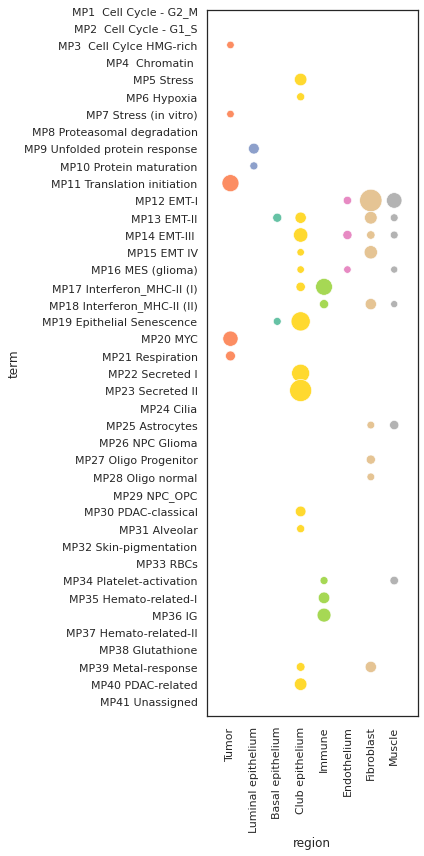

In [36]:
plot_df = dat.copy()

if filter_kw == 'HALLMARK':
    plot_df.index = [s.replace('HALLMARK_','') for s in plot_df.index.tolist()]
    term_list = [s.replace('HALLMARK_','') for s in term_list]

plot_df = plot_df.loc[term_list].reset_index(names='term').melt('term')


plot_df.loc[plot_df['value'] >= 0.05,'value'] = np.nan
plot_df['value'] = -np.log10(plot_df['value'])
plot_df['value'] = plot_df['value'].clip(upper=30) # Cap at a value for contrast
plot_df['overlap'] = overlap_len_df_plot_format['overlap'].copy()

# Define the category labels
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
# Cut the data into 5 custom-named categories
plot_df['value_cat'] = pd.cut(plot_df['value'], bins=5, labels=labels)

# Map regions onto a numberical scale so that the x-axis can be adjusted
plot_df['region'] = plot_df['variable'].map(dict(zip(regions,np.arange(len(regions))+1)))


fig, ax = plt.subplots(figsize=(6,12))
sns.scatterplot(data=plot_df,
                x = 'region',
                y = 'term',
                size='value',
                hue='variable',
                #hue='value_cat',
                #palette='magma',
                palette=sns.color_palette(region_colors),
                sizes=(50,500),
                ax=ax,
                #dropna=False
                )

ax.set_xlim(0,9)
ax.set_yticks(term_list)
ax.set_xticks(np.arange(len(regions))+1)
ax.set_xticklabels(regions,rotation=90)

plt.legend().remove()
plt.tight_layout()
plt.savefig('plots/'+filter_kw+'_gene_set_enrichments_on_regions_dotplot.pdf')
plt.show()

### Check the statistical significance of overlaps between gene sets

In [62]:
region = 'Club epithelium'

set1_name = 'CD300LD downstream'
set1 = set(gene_set_df[set1_name].dropna().tolist())

set2_name = 'MP19 Epithelial Senescence'
set2 = set(gene_set_df[set2_name].dropna().tolist())

# This was already done above
#set2 = set(check_top_markers(region)['gene'].tolist())


gene_universe = set(check_top_markers(region,p_thresh=1.1)['gene'].tolist())

In [63]:
# Test overlap of gene sets
from scipy.stats import fisher_exact
n_universe = len(gene_universe.union(set1).union(set2)) # The number of genes available for DE testing
a = len(set1.intersection(set2))
b = len(set1.difference(set2))
c = len(set2.difference(set1))
d = n_universe - len(set1) - len(set2)
arr = np.array([[a,b],[c,d]])
stat, pval = fisher_exact(arr)

print('Two-sided Fishers exact test p-value: {:.1e}, overlap: {} '.format(pval,a))

Two-sided Fishers exact test p-value: 2.1e-05, overlap: 5 


## Region DEGs PCA

In [ ]:
## Plot a PCA reduction of the log fold-changes of marker genes
## in different regions

In [ ]:
from sklearn.decomposition import PCA
import umap

# All samples with masked IDs
sample_ids = list(sample_id_masks.values())

# This excel contains DEGs for each region in all samples (Wilcoxon test, logFC > 1, padj < 0.05)
region_degs_dict = {}
for reg in regions: 
    region_degs_dict[reg] = pd.read_excel('./supplementary_tables/supp_table_3.xlsx',sheet_name=reg,index_col=0)

In [ ]:
# Format the dataframe

final_df = pd.DataFrame()
for reg in regions:
    #reg = 'Club epithelium'
    df = region_degs_dict[reg].copy()
    df = df.set_index('names')[['sample','logfoldchanges']]

    # Pivot the table
    df = df.pivot(columns='sample')

    # Set a singular column index
    df.columns = df.columns.get_level_values(1)

    # Check which samples are missing from the dataframe
    for s in sample_ids:
        if s not in df:
            df[s] = np.nan

    # Sort the dataframe        
    df = df[sample_ids]

    # Replace spaces with dot
    df.columns = [reg.replace(' ','.') + '_' + s.replace(' ','.') for s in df.columns.tolist()]
    final_df = pd.merge(final_df,df,left_index=True,right_index=True,how='outer')

final_df = final_df.dropna(axis=1,how='all')
final_df = final_df.fillna(0.0)


### Calculate and plot PCA using all the data

In [ ]:
########
# Parameter setup
n_most_variable = 100000
n_principal_comps = 2
do_umap_reduction = False

########

df_for_pca = final_df.copy()
df_for_pca = df_for_pca.loc[df_for_pca.var(axis=1).sort_values(ascending=False)[:n_most_variable].index].copy().T

# Perform PCA
pca = PCA(n_components=n_principal_comps)  # Specify the number of components you want to keep
principal_components = pca.fit_transform(df_for_pca)

# Create a new DataFrame with the principal components
df_reduced = pd.DataFrame(data=principal_components, columns=['PC'+str(i+1) for i in np.arange(n_principal_comps)])

# Get the
explained_variance_ratio = pca.explained_variance_ratio_

# Print the percentage of variance explained by each component
for i, evr in enumerate(explained_variance_ratio):
    print(f"Variance explained by PC{i+1}: {evr:.2f}")
print('\nTotal variance explained {:.2f}'.format(np.sum(explained_variance_ratio)))


if do_umap_reduction:
    # Apply UMAP on the PCA-transformed data
    umap_model = umap.UMAP(n_components=2)
    umap_result = umap_model.fit_transform(principal_components)

    # Create a new DataFrame with UMAP results
    df_reduced = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])


# Set additional columns for plotting the PCA plot
df_reduced['region'] = pd.Categorical([s.split('_')[0].replace('.',' ') for s in df_for_pca.index.tolist()],categories=regions)
df_reduced['sample'] = [s.split('_')[1].replace('.',' ') for s in df_for_pca.index.tolist()]
df_reduced['sample_class'] = pd.Categorical([s.split(' ')[0] for s in df_reduced['sample'].tolist()],categories=['BPH','TRNA','NEADT','CRPC'])

if do_umap_reduction:
    xvar = 'UMAP1'
    yvar = 'UMAP2'
else:
    xvar= 'PC1'
    yvar = 'PC2'
    x_lab = 'PC1 ({:.0%})'.format(explained_variance_ratio[0])
    y_lab = 'PC2 ({:.0%})'.format(explained_variance_ratio[1])

fig,ax = plt.subplots(figsize=(12,9))
sns.scatterplot(df_reduced,
                x = xvar,
                y = yvar,
                hue='region',
                palette=sns.color_palette(list(region_colors_dict.values())),
                style='sample_class',
                s=100,
                ax=ax
                )

if not do_umap_reduction:
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_DEGs_scatterplot.pdf')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
sns.scatterplot(df_reduced,
                x = xvar,
                y = yvar,
                hue='region',
                palette=sns.color_palette(list(region_colors_dict.values())),
                style='sample_class',
                s=100,
                ax=ax
                )

if not do_umap_reduction:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels('')
    ax.set_yticklabels('')

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

ax.legend().remove()

plt.tight_layout()
plt.savefig('./plots/region_DEGs_scatterplot_zoomed.pdf')

plt.show()

### Subset epithelial cells and plot

In [ ]:
########
# Parameter setup
n_most_variable = 100000
n_principal_comps = 2
do_umap_reduction = False

########

df_for_pca = final_df.copy()

# Filter relevant samples
df_for_pca = df_for_pca.loc[:,df_for_pca.columns.str.contains('|'.join([s.replace(' ','.') for s in regions[:4]]))]

# Filter variable genes
df_for_pca = df_for_pca.loc[df_for_pca.var(axis=1).sort_values(ascending=False)[:n_most_variable].index].copy().T

# Perform PCA
pca = PCA(n_components=n_principal_comps)  # Specify the number of components you want to keep
principal_components = pca.fit_transform(df_for_pca)

# Create a new DataFrame with the principal components
df_reduced = pd.DataFrame(data=principal_components, columns=['PC'+str(i+1) for i in np.arange(n_principal_comps)])

# Get the
explained_variance_ratio = pca.explained_variance_ratio_

# Print the percentage of variance explained by each component
for i, evr in enumerate(explained_variance_ratio):
    print(f"Variance explained by PC{i+1}: {evr:.2f}")
print('\nTotal variance explained {:.2f}'.format(np.sum(explained_variance_ratio)))


if do_umap_reduction:
    # Apply UMAP on the PCA-transformed data
    umap_model = umap.UMAP(n_components=2)
    umap_result = umap_model.fit_transform(principal_components)

    # Create a new DataFrame with UMAP results
    df_reduced = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])


# Set additional columns for plotting the PCA plot
df_reduced['region'] = pd.Categorical([s.split('_')[0].replace('.',' ') for s in df_for_pca.index.tolist()],categories=regions)
df_reduced['sample'] = [s.split('_')[1].replace('.',' ') for s in df_for_pca.index.tolist()]
df_reduced['sample_class'] = pd.Categorical([s.split(' ')[0] for s in df_reduced['sample'].tolist()],categories=['BPH','TRNA','NEADT','CRPC'])

if do_umap_reduction:
    xvar = 'UMAP1'
    yvar = 'UMAP2'
else:
    xvar= 'PC1'
    yvar = 'PC2'
    x_lab = 'PC1 ({:.0%})'.format(explained_variance_ratio[0])
    y_lab = 'PC2 ({:.0%})'.format(explained_variance_ratio[1])

fig,ax = plt.subplots(figsize=(12,12))
sns.scatterplot(df_reduced,
                x = xvar,
                y = yvar,
                hue='region',
                palette=sns.color_palette(list(region_colors_dict.values())),
                style='sample_class',
                s=100,
                ax=ax
                )

if not do_umap_reduction:
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)



plt.tight_layout()
plt.savefig('./plots/region_DEGs_scatterplot_epithelial_only.pdf')

plt.show()

## Tampere cohort recurrence analysis 

In [ ]:
yrs_recurrence_thr = 5
to_be_included =  ['untreated'] # ['bicalutamide','goserelin']

# Read and format the recurrence info text
recurrence_info = pd.read_excel('recurrence_information_Tampere.xlsx',index_col=0)

# Drop samples without recurrence information
recurrence_info = recurrence_info[~(recurrence_info['Recurrence'].isna())]

# Set the default recurrence information as 'non-recurrent'
recurrence_info['recurrence_info'] = 'non-recurrent'

#####
# Filter the samples according to treatment information
recurrence_info = recurrence_info[recurrence_info['Prior treatment'].isin(to_be_included)]

######

# Define recurrence as 5-year recurrence
recurrence_info.loc[recurrence_info['progression free months'] <12*yrs_recurrence_thr,'recurrence_info'] = 'recurrent'
recurrence_mapping = recurrence_info['recurrence_info'].to_dict()

recurrence_info['recurrence_info'].value_counts()

In [ ]:
from scripts.utils import get_treatment_info

treat_info = get_treatment_info()
concat_obs = all_obs.copy()

# Define treatment and modify the labels
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)
concat_obs['treatment'] = concat_obs['treatment'].replace({'bicalutamide':'treated','goserelin':'treated'})
concat_obs['treatment'] = concat_obs['treatment'].astype('category')

concat_obs['recurrence'] = concat_obs['sample_id'].map(recurrence_mapping)


def get_spot_proportions(region,column_id,sample_list=samples,obs_data=concat_obs):
    df = pd.DataFrame(index=samples,columns=[region + ' spots','total spots',column_id])
    for sample in sample_list:
        obs_data_subset = obs_data[obs_data['sample_id'] == sample]
        df.loc[sample,'total spots'] = len(obs_data_subset)
        df.loc[sample,region + ' spots'] = len(obs_data_subset[obs_data_subset['predicted_region'] == region])
        df.loc[sample,column_id] = obs_data_subset[column_id][0]

    df['proportion'] = df[region+' spots'] / df['total spots']    
    df['proportion'] = df['proportion'].astype(float)
    
    return(df)


In [ ]:
sns.set_theme(style='whitegrid')

obs_column = 'recurrence'
#order = ['bph', 'untreated', 'treated','crpc']
order = ['non-recurrent','recurrent']
recurrence_info_samples = recurrence_info.index.tolist()

fig, axs = plt.subplots(1,8,figsize=(12,3))
for i, region in enumerate(regions):
    #sns.set_palette(sns.color_palette([color_dict[region]]))    
    #fig, ax = plt.subplots(figsize=(2,3))
    ax = axs[i]
    df = get_spot_proportions(region,obs_column, sample_list=recurrence_info_samples)

    sns.stripplot(x=obs_column, y="proportion", order = order, data=df, size=5, ax=ax, color=color_dict[region]) # color=".7",)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=obs_column,
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            width=0.6,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    #ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels([''])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
    ax.set_yticklabels([''])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig('./plots/region_proportion_swarmplots/all_region_proportions_swarmplot.pdf')

plt.show()

In [ ]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots


from scipy.stats import mannwhitneyu
for region in regions:
    
    df = get_spot_proportions(region,obs_column, sample_list=recurrence_info_samples)

    df = df[~(df[obs_column].isna())]
    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df[obs_column]

    # perform the Kruskal-Wallis test
    statistic, p_value = mannwhitneyu(*[values[categories == cat] for cat in set(categories)])

    print(region)
    if p_value < 0.05:
        # print the results
        print("Mann-Whitney U-test p-value: {:.3f} !!".format(p_value))
    else:
        print("Mann-Whitney U-test p-value: {:.3f}".format(p_value))
    print(' ')


## Score enrichments near a specific region (Figure 4)

In [ ]:

def get_proximity_spots(dat, cluster_of_interest, interaction_clusters = regions.copy(), annotation_key = 'predicted_region',added_key='proximity_analysis'):
    
    
    interaction_clusters = [s for s in interaction_clusters if s != cluster_of_interest]
    n_cluster_of_interest_instances  = (dat.obs[annotation_key] == cluster_of_interest).sum()

    if n_cluster_of_interest_instances >= 10:

        # Create an observation column for spatial segmentation
        dat.obs[added_key] = 'Distant'
        dat.obs[added_key] = dat.obs[added_key].astype('category').cat.set_categories([cluster_of_interest, 'Proximal','Distant'])

        distance_mat = dat.obsp['spatial_distances'].todense()

        for idx, obs_name in enumerate(dat.obs_names):
            
            cl = dat.obs[annotation_key][idx]
            first_nhbor_idxs = np.where(distance_mat[:,idx]==1.0)[0] # Get first-term neighbor indices

            # The obs in question is annotated as the region of interest AND it is neighbored by at least one another
            # spot of the same region
            if (cl == cluster_of_interest) & (dat[first_nhbor_idxs].obs[annotation_key].str.contains(cl).any()):
                
                # Annotate this one as 'cl'
                dat.obs.loc[obs_name,added_key] = cl

                # Get the spot indices that are proximal
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                # Annotate all neighbors that are in 'interaction_clusters' as 'Proximal':
                
                col = dat.obs.iloc[all_nhbor_indices][annotation_key] # Get proximal spots and their values
                idxs = col[col.isin(interaction_clusters)].index # Get the indices of spots that are proximal and in interaction_clusters
                dat.obs.loc[idxs,added_key] = 'Proximal' # Set those clusters as 'Proximal'
                
            else:
                # The observation is not from the cluster of interest, move onto the next obs
                continue

        return dat

    else: 
        print('Not enough cluster of interest indices ({:.0f})'.format(n_cluster_of_interest_instances))
        print()
        return dat


In [ ]:
roi = 'Club epithelium'

# Initialize the proximity object
all_obs['proximity_analysis'] = np.NaN

for s in tqdm(samples,desc='Processing samples'):

    slide = sc.read_h5ad('./data/visium_with_regions/'+s+'_with_regions.h5ad')

    slide.obs = pd.concat([slide.obs,scanpy_res.loc[slide.obs_names]],axis=1)
    slide = get_proximity_spots(slide,roi)

    if 'proximity_analysis' in slide.obs.columns:
        
        # Add the proximity analysis annotation into the concatenated observations object
        all_obs.loc[slide.obs.index,'proximity_analysis'] = slide.obs['proximity_analysis']
        

        ################## PLOT ##################

        slide.uns['proximity_analysis_colors'] = [region_colors_dict[roi],'#87ceeb','#e0e0e0']
        sns.set_theme(style='white')

        # Create the figure and subplots
        fig = plt.figure(figsize=(12, 6))

        # Add the left subplot
        ax1 = fig.add_subplot(1, 2, 1)
        sc.pl.spatial(slide,color='proximity_analysis',title=s,
                                crop_coord=sample_crop_coord[s],
                                size=1.3, alpha_img=1, legend_loc=None,
                                ax=ax1, show=False
                                )

        sns.set_theme(style='whitegrid')
        # Add the top and bottom right subplot
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)

        sns.violinplot(data=slide.obs, x='proximity_analysis', y='CD300LD downstream',palette=sns.color_palette(slide.uns['proximity_analysis_colors']),ax=ax2)
        sns.violinplot(data=slide.obs, x='proximity_analysis', y='MDSC Calcinotto 2018',palette=sns.color_palette(slide.uns['proximity_analysis_colors']),ax=ax3)

        ax2.set_xlabel(None)
        ax3.set_xlabel(None)

        del slide
        # Adjust the spacing between subplots
        plt.tight_layout()

        plt.savefig('plots/proximal_score_enrichments/'+s+'_club_immune_score_enrichments.pdf')
        plt.clf()

        #plt.show()

all_obs['proximity_analysis'].to_csv('data/region_ligrec_analysis/'+'Club_epithelium_3_rings_all_other_regions.csv')


## Pseudobulk score correlations + Venn diagrams (Figure 3c)

### Pseudobulk score – region proportion comparisons

In [7]:
sns.set_theme(style='white')


# Get the proportion of each region in each sample into a dataframe
def calculate_spot_proportions(obs_df = all_obs,sample_list = samples, region_list = regions):
    proportion_df = pd.DataFrame(index=samples,columns=region_list)
    for s in sample_list:

        slide = obs_df[obs_df['sample_id'] == s]
        val_counts = slide['predicted_region'].value_counts()

        # Add any missing regions
        for reg in region_list:
            if reg not in val_counts.index:
                val_counts.loc[reg] = 0 
        
        # Sort the values to a correct region order
        proportion_df.loc[s] = val_counts[region_list].values
    proportion_df = proportion_df.div(proportion_df.sum(axis=1),axis=0).astype(float)

    return(proportion_df)

proportion_df = calculate_spot_proportions()
proportion_df['sample_class'] = proportion_df.index.map(sample_class_dict)

In [10]:
roi = 'Club epithelium'
pseudobulk_df = pd.DataFrame()

for s in tqdm(samples,desc='Samples processed:'):

    # Ignore spots that belong to the region which' proportion you want to correlate (remove confounding effect)
    slide = sc.read_h5ad('./data/visium_with_regions/'+s+'_with_regions.h5ad')

    # Take out spots annotated as the region of interest
    slide = slide[slide.obs['predicted_region'] != roi]

    # Concatenate the raw count layer into a pseudobulk sample
    s_pseudobulk_df = pd.DataFrame(slide.layers['counts'].sum(axis=0).T,index=slide.var.index,columns=[s])
    
    # Merge to create a dataframe with samples as columns, genes as index
    pseudobulk_df = pd.merge(pseudobulk_df,s_pseudobulk_df,left_index=True,right_index=True,how='outer')

    del slide


# Fill empty
pseudobulk_df = pseudobulk_df.fillna(0)

# Make into an anndata object for scanpy compatibility
pseudobulk_adata = ad.AnnData(pseudobulk_df.values.T,var=pd.DataFrame(index=pseudobulk_df.index),obs=pd.DataFrame(index=pseudobulk_df.columns))

# Save the raw counts
pseudobulk_adata.layers['counts'] = pseudobulk_adata.X.copy()

# Preprocess and normalize using standard methods (NOTE: single-cell/spatial pipeline uses scran-normalization)
sc.pp.filter_genes(pseudobulk_adata,min_cells=10)
sc.pp.normalize_total(pseudobulk_adata,target_sum=1e4)
sc.pp.log1p(pseudobulk_adata)

# Score genes and add the identifier to obs
for mod in gene_modules:
    sc.tl.score_genes(pseudobulk_adata,gene_set_df[mod].dropna(),score_name=mod)

# Concatenate with the sample-specific region proportion dataframe
proportion_df_pseudobulk_method = pd.concat([proportion_df,pseudobulk_adata.obs],axis=1)



Samples processed:: 100%|██████████| 48/48 [00:55<00:00,  1.16s/it]

### Plot the pseudobulk method correlation plots

In [11]:
sns.set_theme(style='white')

classes_to_keep = ['BPH','TRNA','NEADT','CRPC'] 

treat_colors_dict = {
    'BPH':'#1f77b4',
    'TRNA':'#ff7f0e',
    'NEADT':'#2ca02c', 
    'CRPC':'#d62728',
}
 
sns.set_palette(sns.color_palette([treat_colors_dict[k] for k in classes_to_keep]))
df = proportion_df_pseudobulk_method[proportion_df_pseudobulk_method['sample_class'].isin(classes_to_keep)]

In [13]:

# Calculate correlation p-values
pvals = []
for mod in gene_modules:

    corr_coef, p_value = spearmanr(df[roi], df[mod])
    pvals.append(p_value)

# Correct p-values and save them into a dict
corrected_pvals = fdrcorrection(pvals,alpha=0.05,method='indep')
corrected_pvals_dict = dict(zip(gene_modules.tolist(),corrected_pvals[1]))

# Create figure save folder if not existing
Path('plots/score_correlations/'+roi.replace(' ','_')).mkdir(exist_ok=True)

for mod in corrected_pvals_dict.keys():
    #if corrected_pvals_dict[mod] < 0.05:
    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=roi, y=mod, data=df, hue='sample_class', linewidth=0.1, s=30, ax=ax,legend=False) # 

    # add regression line to plot
    sns.regplot(x=roi, y=mod, data=df, scatter=False, ax=ax,color='gray')

    #ax.set_ylim(-0.5,1.0)
    #ax.set_xlim(0,1.2)
    corr_coef, _ = spearmanr(df[roi], df[mod])
    corrected_pval = corrected_pvals_dict[mod]

    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {corrected_pval:.2e}")

    if roi == 'Club epithelium':
        ax.set_xlabel('Club region proportion') ### CHECK THAT IS CORRECT
    plt.tight_layout()

    plt.savefig('plots/score_correlations/'+roi.replace(' ','_')+'/region_proportion_vs_'+mod+'_'+'_'.join(classes_to_keep)+'.pdf')
    plt.clf()

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

### Venn diagrams of gene module overlaps + score correlation plots

In [1]:
sns.set_theme(style='white')
from venn import venn

gene_set_df.rename(columns={'NLR associated':'High NLR-associated'},inplace=True)

set1_name = 'Club' 
set2_name = 'MP19 Epithelial Senescence'
set3_name = 'HALLMARK_IL6_JAK_STAT3_SIGNALING'
set4_name = 'High NLR-associated'
venn_data = {
            set1_name: set(gene_set_df[set1_name].dropna()),
            set2_name: set(gene_set_df[set2_name].dropna()),
            set3_name: set(gene_set_df[set3_name].dropna()),
            set4_name: set(gene_set_df[set4_name].dropna())
            }
fig,ax = plt.subplots(figsize=(8,8))
# Create the Venn diagram
venn(venn_data,ax=ax)
#plt.savefig('plots/score_correlations/venn_'+set1_name+'_'+set2_name+'_'+set3_name+'_'+set4_name+'.pdf')
# Display the diagram
plt.show()

NameError: name 'sns' is not defined

In [ ]:
from itertools import combinations
gene_module_pairs = list(combinations(gene_modules,2))

In [ ]:
# Here pearson is valid as we're comparing signature enrichment in thousands of spots

masked_ids = list(get_sample_id_mask().values())
from scipy.stats import pearsonr
sns.set_theme(style='white')

reg = regions[3]
sample_classes = ['CRPC']#['BPH','TRNA','NEADT','CRPC']
score1 = 'Club'
score2 = 'NLR associated'

gene_module_pairs = [(score1,score2)]
for mod_pair in gene_module_pairs:
    
    score1 = mod_pair[0]
    score2 = mod_pair[1]        
    # Get the samples you want
    valid_samples = []
    for sclass in sample_classes:
        for s in masked_ids:
            if sclass in s:
                valid_samples.append(s)

    scores_df = all_obs[(all_obs['predicted_region'] == reg) & (all_obs['masked_id'].isin(valid_samples))]

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=scores_df, color = region_colors_dict[reg], linewidth=0.1, s=2, ax=ax) # 

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=scores_df, scatter=False, ax=ax,color='gray')

    ax.set_ylim(-0.5,1.0)
    ax.set_xlim(0,1.2)

    corr_coef, p_value = pearsonr(scores_df[score1], scores_df[score2])
    ax.text(x=0.05, y=1.1, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    #ax.text(x=0.05, y=scores_df[score2].max()+0.1, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()
    plt.savefig('plots/score_correlations/'+score1+'_'+score2+'_in_'+'_'.join(sample_classes)+'_'+reg+'.png',dpi=1200)
    plt.show()


## Visualize score enrichments in regions (violin plots)

### Filter samples & score names

In [ ]:
treatment_naive_samples = get_sample_ids_reorder(['BPH','untreated'])
only_treat_naive = False

from scipy.stats import ttest_1samp
sns.set_theme(style='whitegrid')
sns.set_palette(region_colors)

df = all_obs.copy()

In [ ]:
for col in tqdm(gene_modules,desc='Gene modules'):

#for col in ['MP19 Epithelial Senescence', 'MP23 Secreted II', 'Persist', 'CRPC-SCL']:
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120)


    if only_treat_naive:
        # Take only the treatmeent naives samples
        df_to_plot = df[df['sample_id'].isin(treatment_naive_samples)][['sample_id',col,'predicted_region']]

    else:
        # No sample filtering
        df_to_plot = df[['sample_id',col,'predicted_region']]

    score_mean = df_to_plot[col].mean()

    # Since the scores are run on z-normalized data, the overall mean is 0
    ax.axhline(score_mean, linestyle='--', color='black') 

    sns.violinplot(data=df_to_plot, x='predicted_region', y=col,ax=ax,legend=False)

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.25
    ax.set(ylim=(ymin, ymax))
    #plt.legend().remove()

    for idx,reg in enumerate(regions):

        reg_scores = df_to_plot[df_to_plot['predicted_region']==reg][col]

        if ttest_1samp(reg_scores,0,axis=None,alternative='greater')[1] <0.01:

            t_stat, p_val = ttest_1samp(reg_scores,score_mean,axis=None,alternative='greater')

            ## Make p-value and magnitude requirements
            if p_val<0.05 and ((score_mean < reg_scores.quantile(0.1))):
                asterisks = '***'
            elif p_val<0.05 and ((score_mean < reg_scores.quantile(0.2))):
                asterisks = '**'
            elif p_val<0.05 and ((score_mean < reg_scores.quantile(0.3))):
                asterisks = '*'
            else:
                asterisks = ''
                
            ax.text(idx, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')
            
            #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.set_xticklabels([], rotation=15)
        
    plt.tight_layout()
    
    if only_treat_naive:
        plt.savefig('./plots/score_violins/untreated/scanpy_'+col.replace('/','_')+'_untreated.pdf')
    else: 
        plt.savefig('./plots/score_violins/all_samples/scanpy_'+col.replace('/','_')+'_all.pdf')
    plt.clf()
    #plt.show()

### Plot Club region vs other epithelial as a side-by-side violin


In [4]:
from scipy.stats import ttest_ind

sns.set_theme(style='whitegrid')
only_epithelial_regions = True
epithelial_regions = regions[:4]

df = all_obs.copy()

<Figure size 360x360 with 0 Axes>

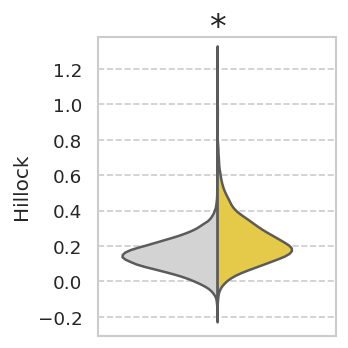

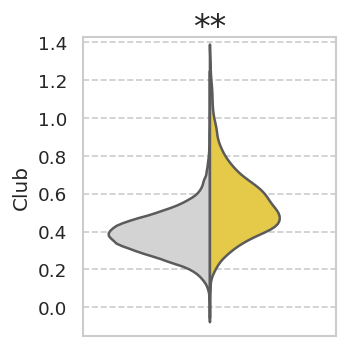

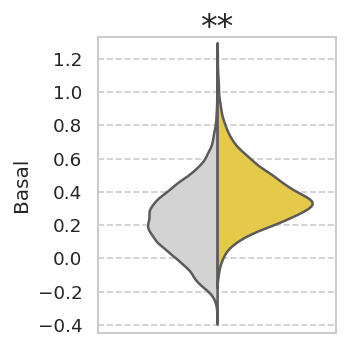

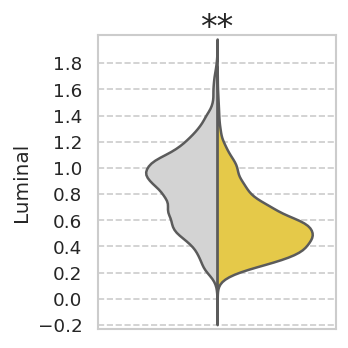

<Figure size 360x360 with 0 Axes>

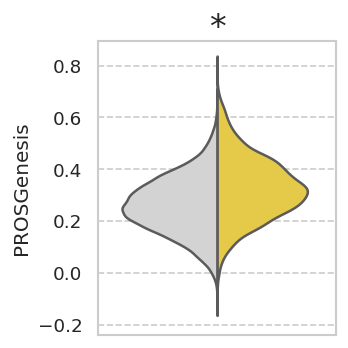

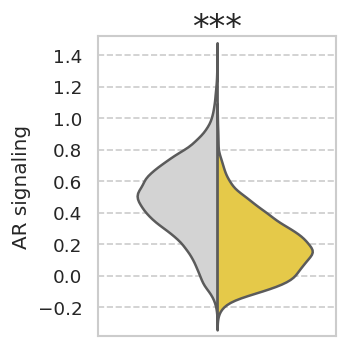

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

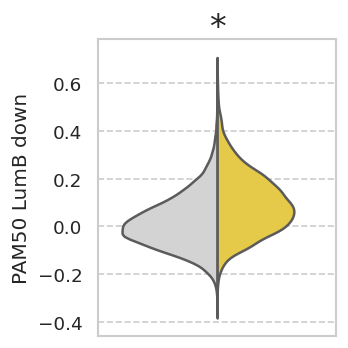

<Figure size 360x360 with 0 Axes>

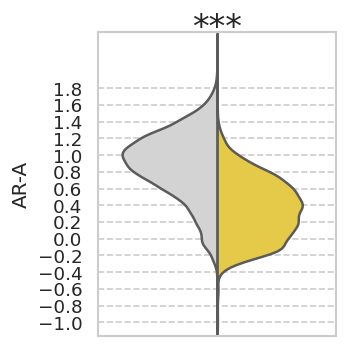

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

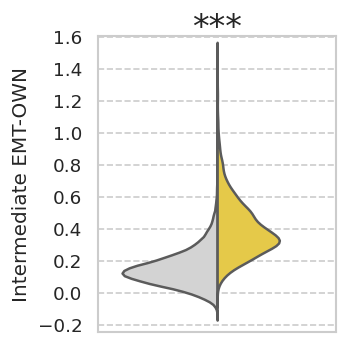

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

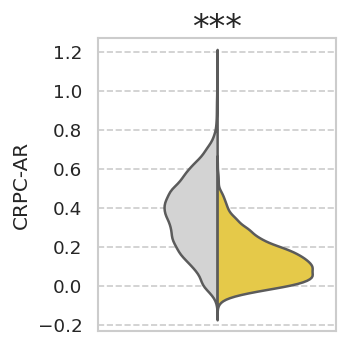

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

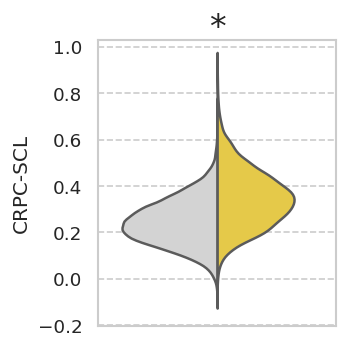

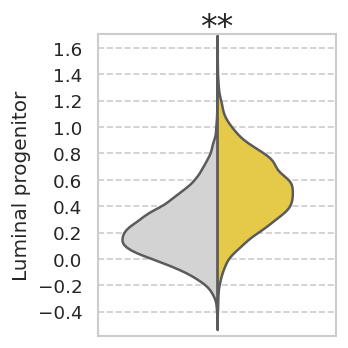

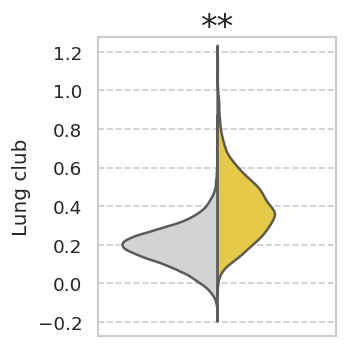

<Figure size 360x360 with 0 Axes>

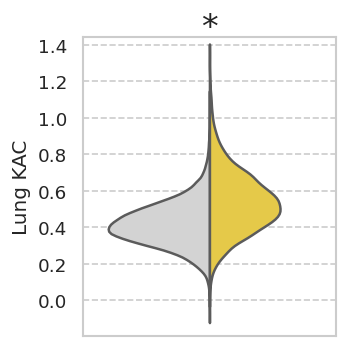

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

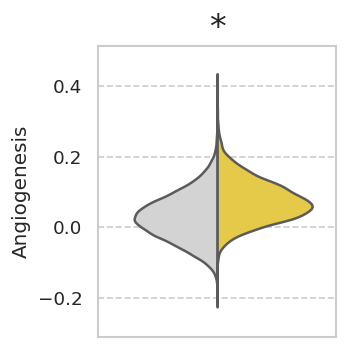

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

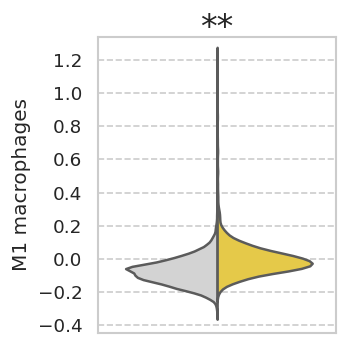

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

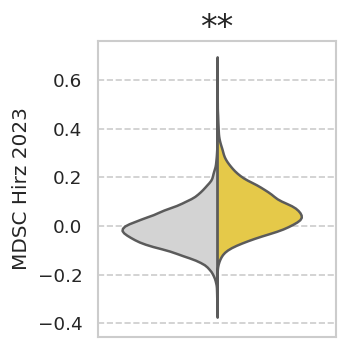

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

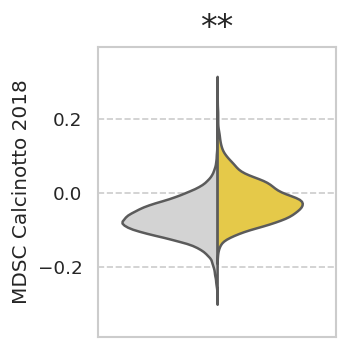

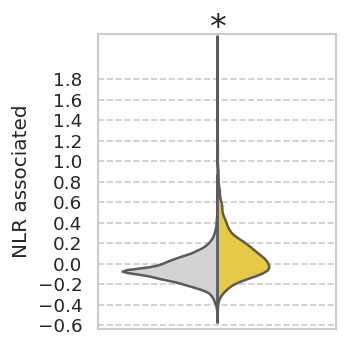

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

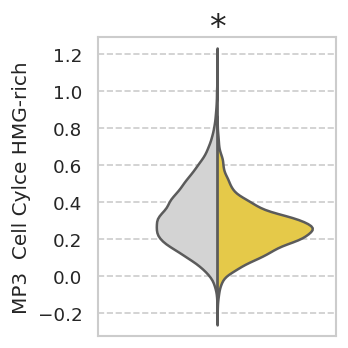

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

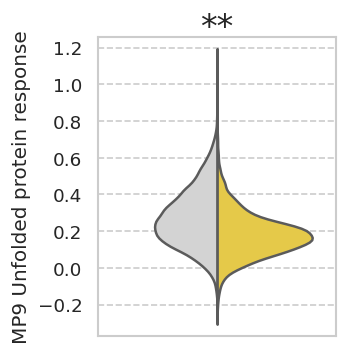

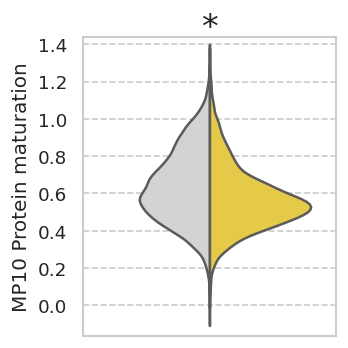

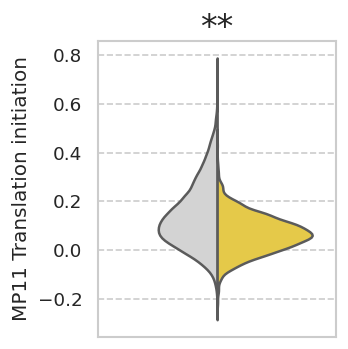

<Figure size 360x360 with 0 Axes>

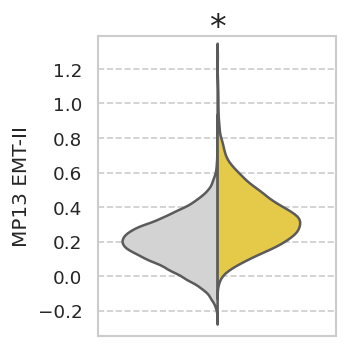

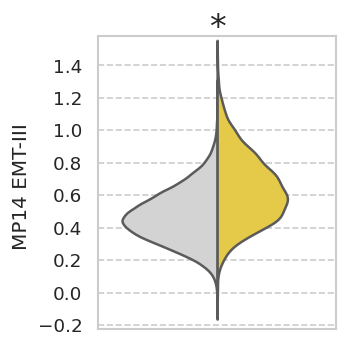

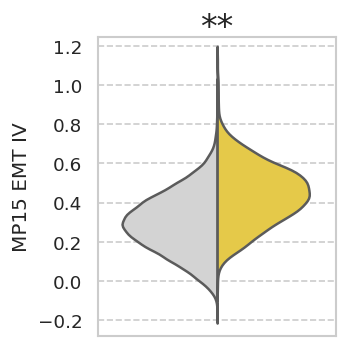

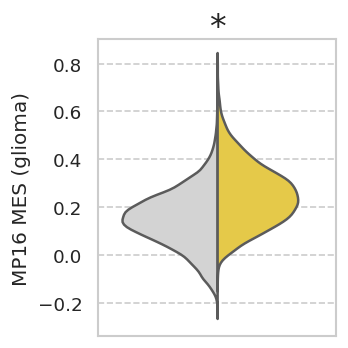

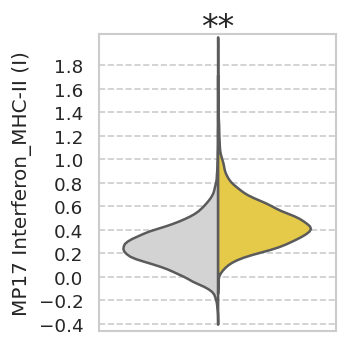

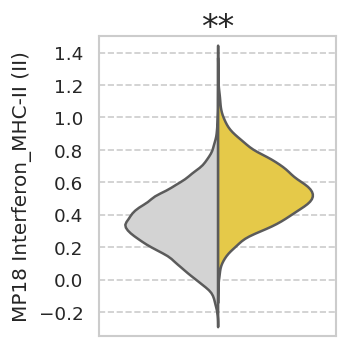

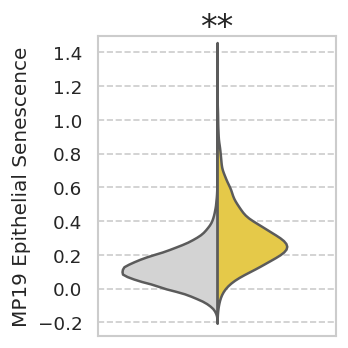

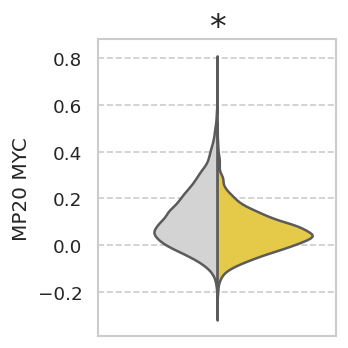

<Figure size 360x360 with 0 Axes>

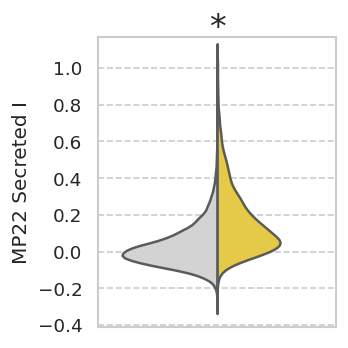

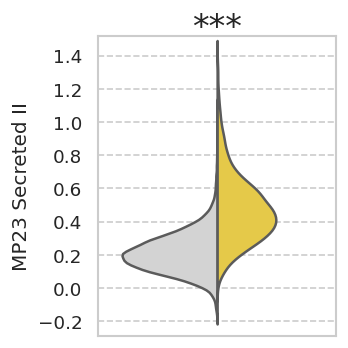

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

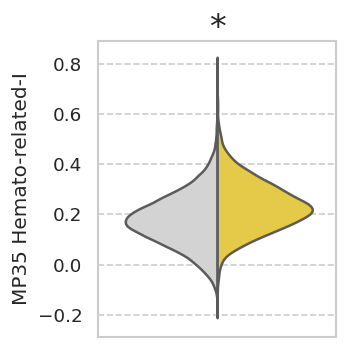

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

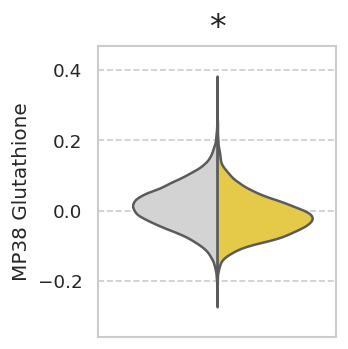

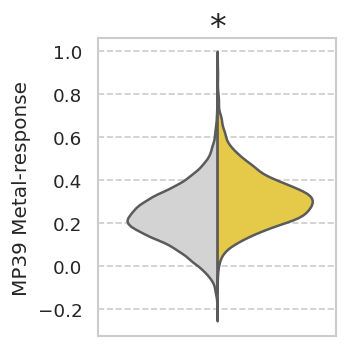

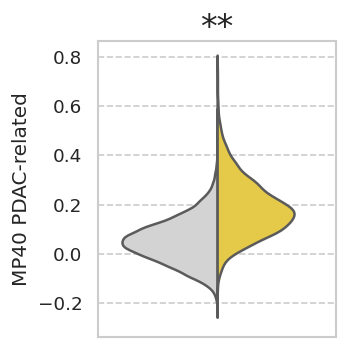

<Figure size 360x360 with 0 Axes>

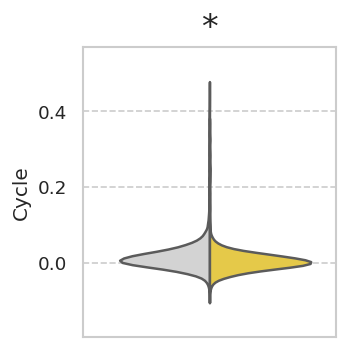

<Figure size 360x360 with 0 Axes>

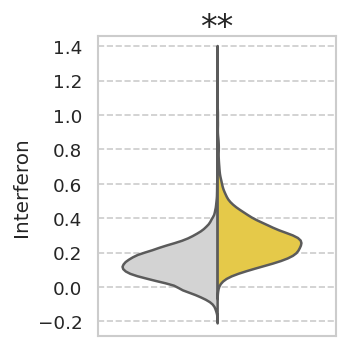

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

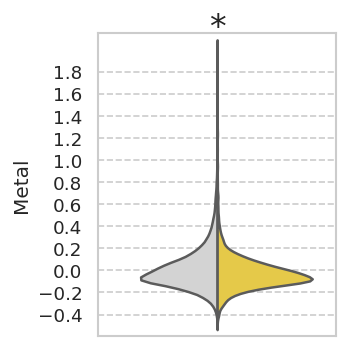

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

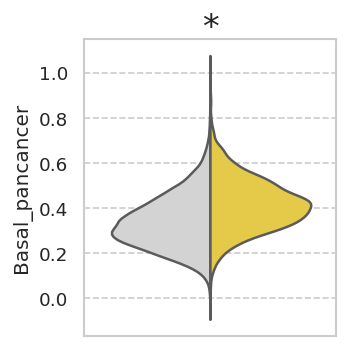

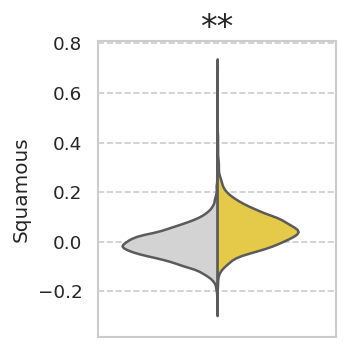

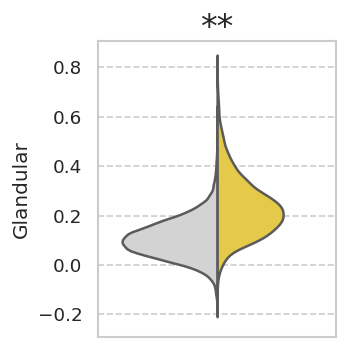

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

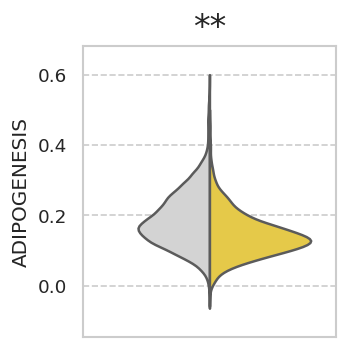

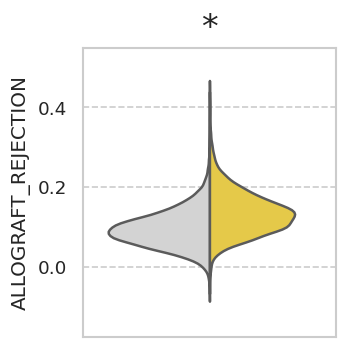

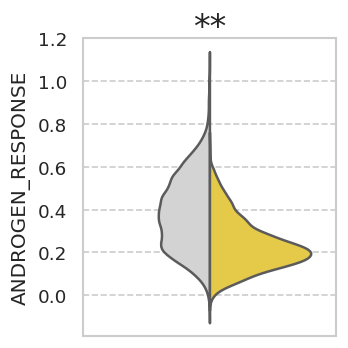

<Figure size 360x360 with 0 Axes>

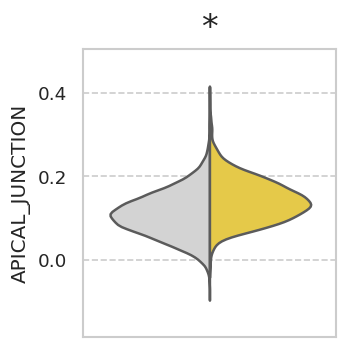

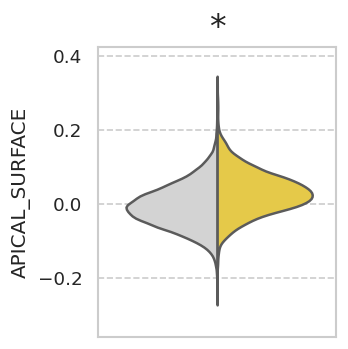

<Figure size 360x360 with 0 Axes>

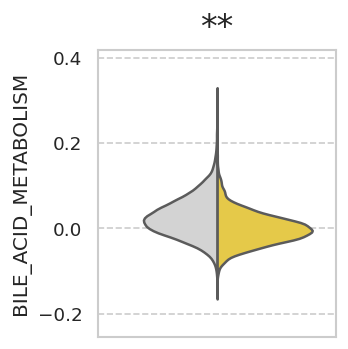

<Figure size 360x360 with 0 Axes>

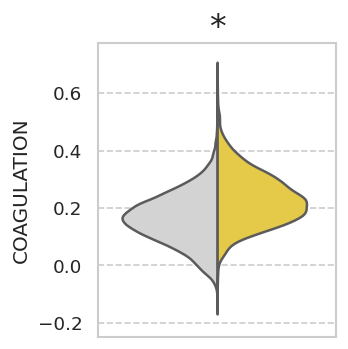

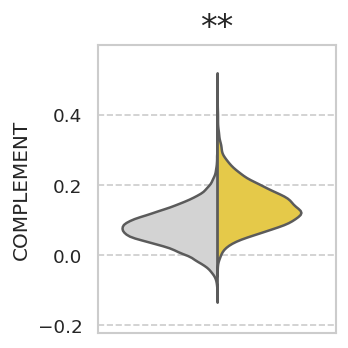

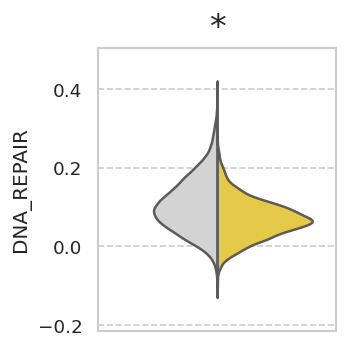

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

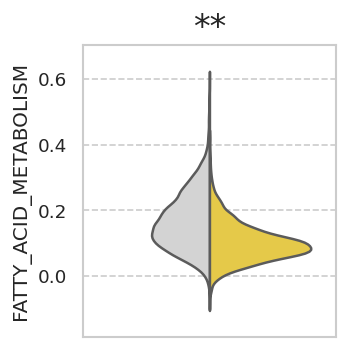

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

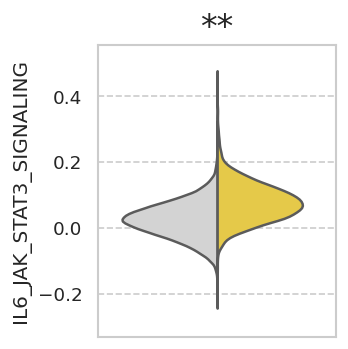

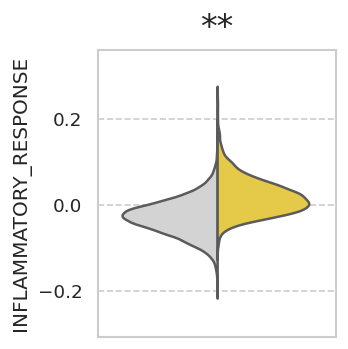

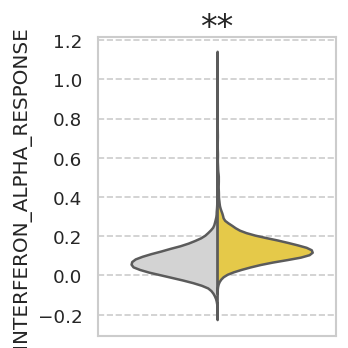

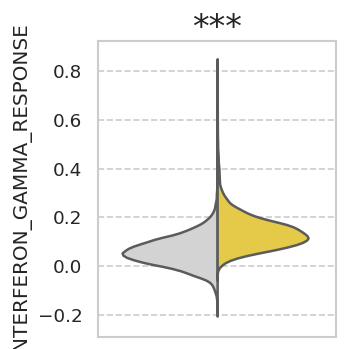

<Figure size 360x360 with 0 Axes>

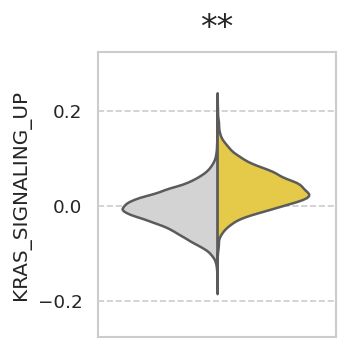

<Figure size 360x360 with 0 Axes>

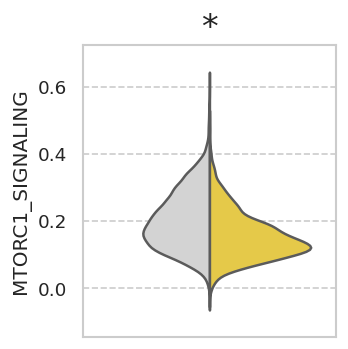

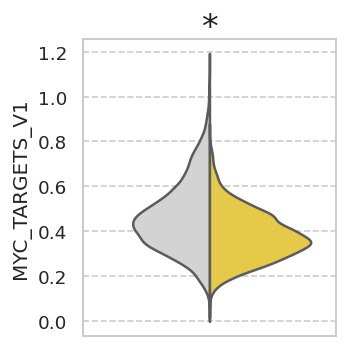

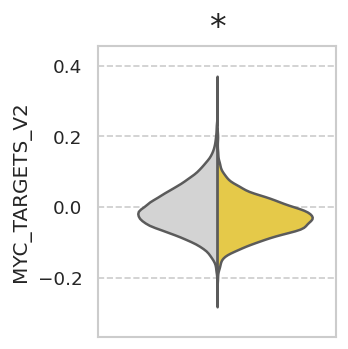

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

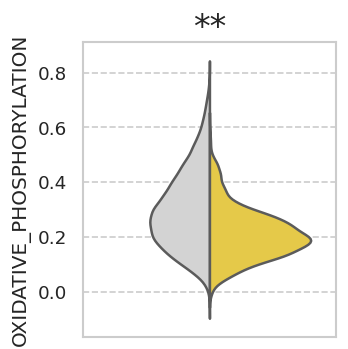

<Figure size 360x360 with 0 Axes>

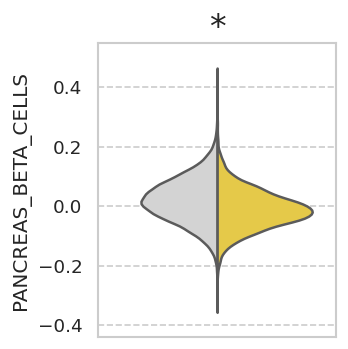

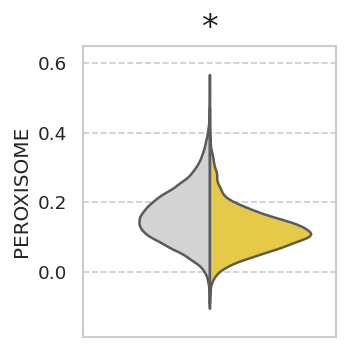

<Figure size 360x360 with 0 Axes>

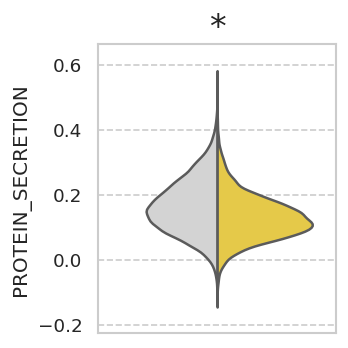

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

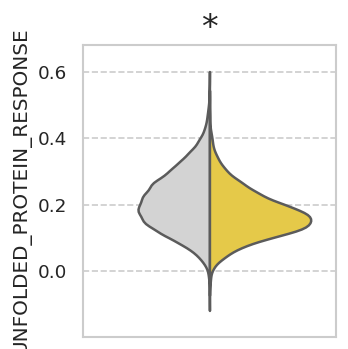

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

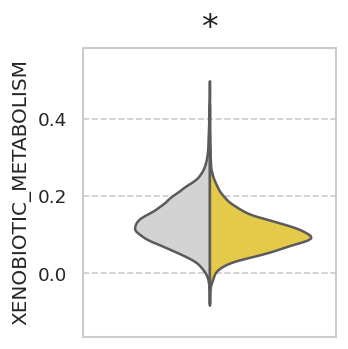

In [5]:
#modules_of_interest = ['HALLMARK_TNFA_SIGNALING_VIA_NFKB']
modules_of_interest = gene_modules
region_of_interest = 'Club epithelium'


region_selection_dict = dict(zip(regions,[region if region == region_of_interest else 'Other' for region in regions]))


for col in modules_of_interest:

    fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

    # No sample filtering
    df_to_plot = df[['sample_id',col,'predicted_region']]


    if only_epithelial_regions:
        df_to_plot = df_to_plot[df_to_plot['predicted_region'].isin(epithelial_regions)]

    df_to_plot['regions_to_plot'] = df_to_plot['predicted_region'].map(region_selection_dict).astype('category')

    df_to_plot['regions_to_plot'] = df_to_plot['regions_to_plot'].cat.set_categories(['Other',region_of_interest])
    df_to_plot['foo'] = 'bar'

    sns.set_palette(sns.color_palette(['lightgrey',region_colors_dict[region_of_interest]]))

    sns.violinplot(data=df_to_plot,x='foo', hue='regions_to_plot', y=col,ax=ax,inner=None,split=True,legend=False)
    ax.get_legend().remove()

    # Plot y-axis lines between known interwals
    plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.1

    ax.set(ylim=(ymin, ymax))
    
    # Do the t-tests
    sample = df_to_plot[df_to_plot['regions_to_plot']==region_of_interest][col]
    control = df_to_plot[~(df_to_plot['regions_to_plot']==region_of_interest)][col]

    stat,p_val = ttest_ind(sample,control)

    ## Make p-value and magnitude requirements
    if p_val<0.05 and ((control.mean() < sample.quantile(0.1)) or (control.mean() > sample.quantile(0.9))):
        asterisks = '***'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.2)) or (control.mean() > sample.quantile(0.8))):
        asterisks = '**'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.3)) or (control.mean() > sample.quantile(0.7))):
        asterisks = '*'
    else:
        asterisks = ''
        
    ax.text(0, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')
        

    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_ylabel(col.replace('HALLMARK_',''))

    ax.set_xlabel('')
    plt.tight_layout()
    
    plt.savefig('./plots/score_violins/club_vs_other_epithelial/scanpy_'+col.replace('/','_')+'_score.pdf')
    if asterisks != '':
        plt.show()
    else:
    #    plt.show()
        plt.clf()

## Visualize gene set activity scores in relation to treatment

### Treatment comparison

In [120]:
from scipy.stats import ttest_ind
sns.set_theme(style='whitegrid')

pal = sns.color_palette(['lightcoral','lightgreen'])
sns.set_palette(pal)

df = all_obs.copy()
# Keep only TRNA - NEADT
df = df[df['sample_class'].isin(['TRNA','NEADT'])]

In [130]:
sns.set_palette(sns.color_palette(['#F28E2B','#59A14F']))

for col in tqdm(gene_modules,desc='Processing module'):

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)

    df_to_plot = df[['sample_id',col,'sample_class','predicted_region']]

    df_to_plot['sample_class'] = df_to_plot['sample_class'].astype('category').cat.set_categories(['TRNA','NEADT'])
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].astype('category').cat.set_categories(regions)

    # Plot y-axis lines between known interwals
    plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    ymin = df_to_plot[col].min()-0.2
    ymax = df_to_plot[col].max()+0.2

    ax.set(ylim=(ymin, ymax))

    ax = sns.violinplot(data=df_to_plot, x='predicted_region', y=col, hue='sample_class',ax=ax,split=True, inner = None)
    ax.set(ylim=(ymin, ymax))

    for idx,reg in enumerate(regions):

        groups = [group[col] for name, group in df_to_plot[df_to_plot['predicted_region']==reg].groupby('sample_class')]
        f_stat, p_val = ttest_ind(*groups)

        ## Make p-value and magnitude requirements
        if p_val<0.05 and ((groups[0].mean() > groups[1].quantile(0.9)) or (groups[0].mean() < groups[1].quantile(0.1))):
            asterisks = '***'
        elif p_val<0.05 and ((groups[0].mean() > groups[1].quantile(0.8)) or (groups[0].mean() < groups[1].quantile(0.2))):
            asterisks = '**'
        elif p_val<0.05 and ((groups[0].mean() > groups[1].quantile(0.7)) or (groups[0].mean() < groups[1].quantile(0.3))):
            asterisks = '*'
        else:
            asterisks = ''
            
        ax.text(idx, ymax +0.05, asterisks, fontsize=20,ha='center', va='center')
        
        #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    #ax.legend(loc='lower right')
    ax.legend_.remove()
    ax.set_xlabel('')
        
    plt.tight_layout()
    plt.savefig('./plots/score_violins/treatment_comparison/'+col.replace('/','_')+'_by_regions_PCa_treatment.pdf')
    plt.clf()
    #plt.show()

Processing module: 100%|██████████| 153/153 [01:53<00:00,  1.35it/s]


<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

### Draw score correlation plots

In [ ]:
unt = ['bph','untreated']
treated = ['bicalutamide','goserelin']
scores = ['AR signaling','Persist','CRPC-SCL','MP22 Secreted I','MP17 Interferon/MHC-II (I)','MP18 Interferon/MHC-II (II)','MP23 Secreted II','MP19 Epithelial Senescence']

In [ ]:
from scipy.stats import pearsonr
from itertools import combinations
from matplotlib import pyplot as plt

score_combs = list(combinations(scores,2))

sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(region_colors))



for score_tuple in score_combs:
    score1 = score_tuple[0]
    score2 = score_tuple[1]

    untreated_scores = df[df['treatment'].isin(unt)]#.sample(frac=0.1)
    treated_scores = df[df['treatment'].isin(treated)]#.sample(frac=0.1)

    xmin = df[score1].min()
    xmax = df[score1].max()-0.2
    ymin = df[score2].min()
    ymax = df[score2].max()-0.2

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=untreated_scores, hue='predicted_region', s=1, ax=axs[0])

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=untreated_scores, scatter=False, ax=axs[0],color='gray')

    # Add cluster centres on the plot
    sns.scatterplot(x=score1,y=score2,
    data=untreated_scores[[score1,score2,'predicted_region']].groupby('predicted_region').mean().reset_index(),
    hue='predicted_region',s=300,marker='x',ax=axs[0])

    # add correlation coefficient and p-value to plot
    corr_coef, p_value = pearsonr(untreated_scores[score1], untreated_scores[score2])
    axs[0].text(x=0.05, y=0.95, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}", transform=axs[0].transAxes)

    ############################
    # In treated samples

    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=treated_scores, hue='predicted_region', s=1, ax=axs[1])

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=treated_scores, scatter=False, ax=axs[1],color='gray')

    sns.scatterplot(x=score1,y=score2,
    data=treated_scores[[score1,score2,'predicted_region']].groupby('predicted_region').mean().reset_index(),
    hue='predicted_region',s=300,marker='x',ax=axs[1])

    # add correlation coefficient and p-value to plot
    corr_coef, p_value = pearsonr(treated_scores[score1], treated_scores[score2])
    axs[1].text(x=0.05, y=0.95, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}", transform=axs[1].transAxes)

    axs[0].set_xlim(xmin,xmax)
    axs[0].set_ylim(ymin,ymax)

    axs[1].set_xlim(xmin,xmax)
    axs[1].set_ylim(ymin,ymax)

    axs[0].legend_.remove()
    axs[1].legend_.remove()
    # display the plot
    plt.tight_layout()

    #plt.savefig('plots/score_correlations/'+score1+'_'+score2+'.png')
    #plt.clf()
    plt.show()
